# Лекция 3
## Модели ARIMA и GARCH

Данные для лекции выложены в [репозитории](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.3/Series) GitHub или на [гугл-диске](https://drive.google.com/open?id=1ZE6MsXuzPh-dbugsAV-8Ywu9fCC688WG)

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -30.951862
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


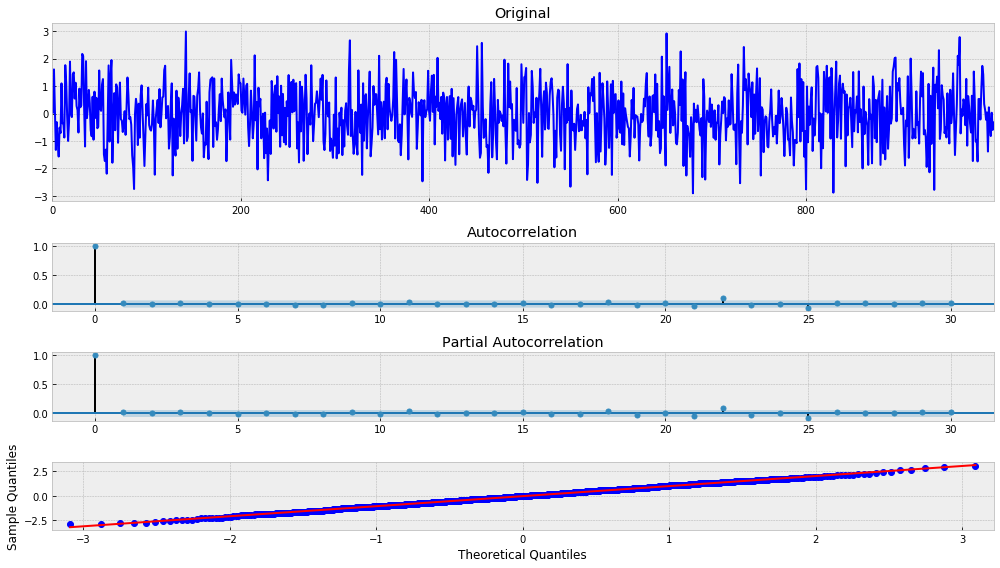

In [6]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность белого шума в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс белого шума

In [9]:
x = np.random.normal(size=1000)

Давайте проверим, подходит ли модель белого шума под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -1.336411e+01
p-value                        5.355690e-25
#Lags Used                     1.600000e+01
Number of Observations Used    9.820000e+02
Critical Value (1%)           -3.437027e+00
Critical Value (5%)           -2.864488e+00
Critical Value (10%)          -2.568340e+00
dtype: float64


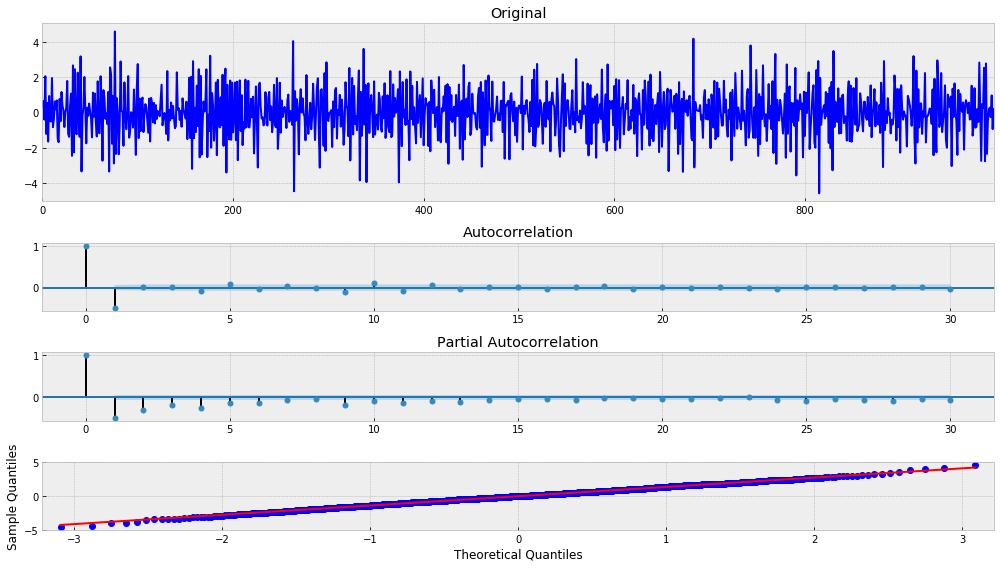

In [10]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


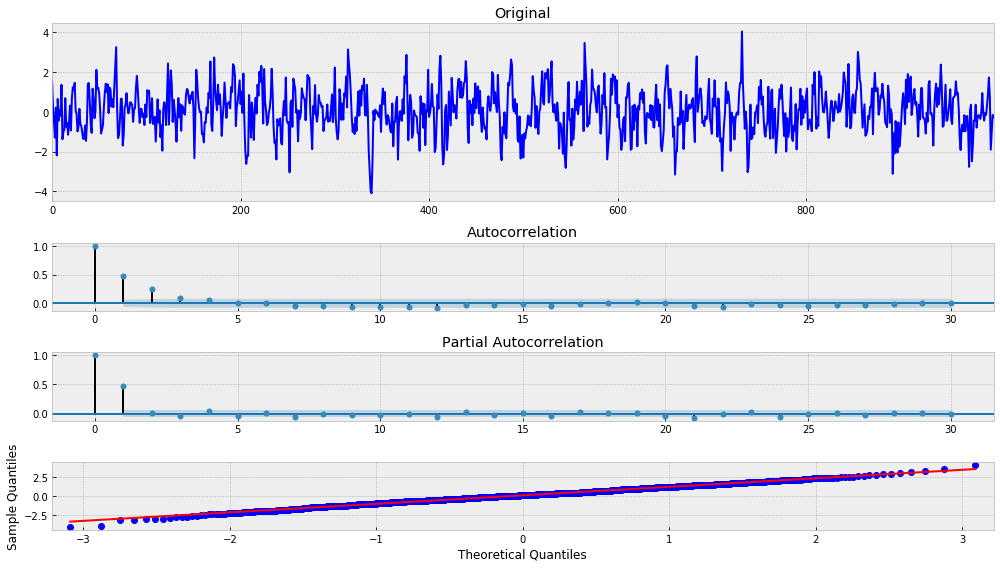

In [11]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [12]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

In [18]:
series = pd.read_csv("../data/international-airline-passengers.csv")
series.columns = ['Month', 'Count']
series = series['Count']

Results of Dickey-Fuller Test:


C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


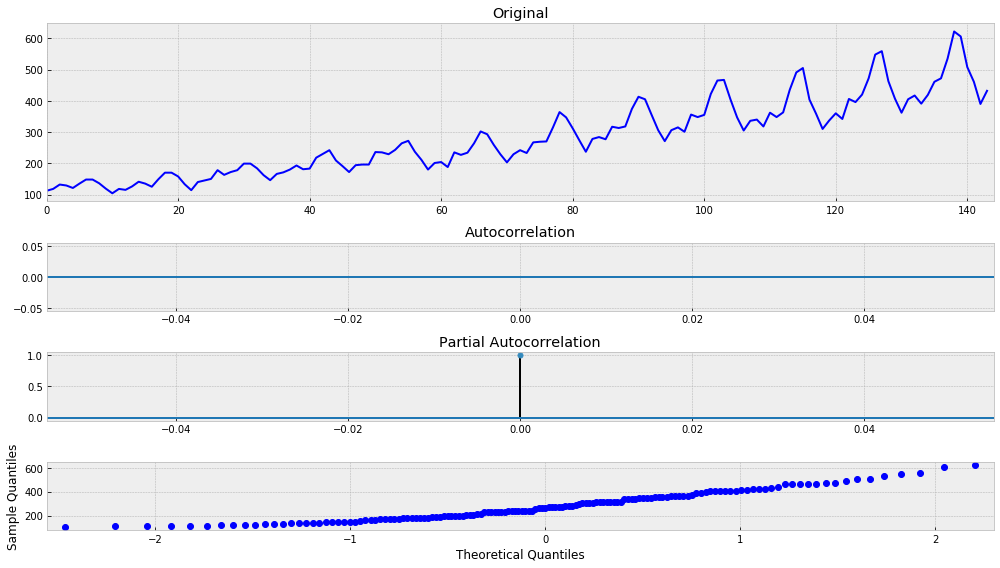

In [19]:
tsplot(series)

In [103]:
mdl = smt.AR(series.values).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[ 0.53592704  0.27340801  0.05802295 -0.18923401  0.30875278 -0.01819355
 -0.10777449 -0.06628879  0.40935669 -0.43338994 -0.04113904  0.79817779
 -0.1102863  -0.54481521  0.12659708  0.05725264 -0.15575603 -0.2144721
  0.31196295 -0.14509167 -0.20345252  0.24794335  0.31668342  0.04862086
 -0.23626175]


## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARIMA

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7105.938
Method:                           mle   S.D. of innovations              1.002
Date:                Tue, 10 Mar 2020   AIC                          14221.876
Time:                        22:17:45   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                                                                              
              

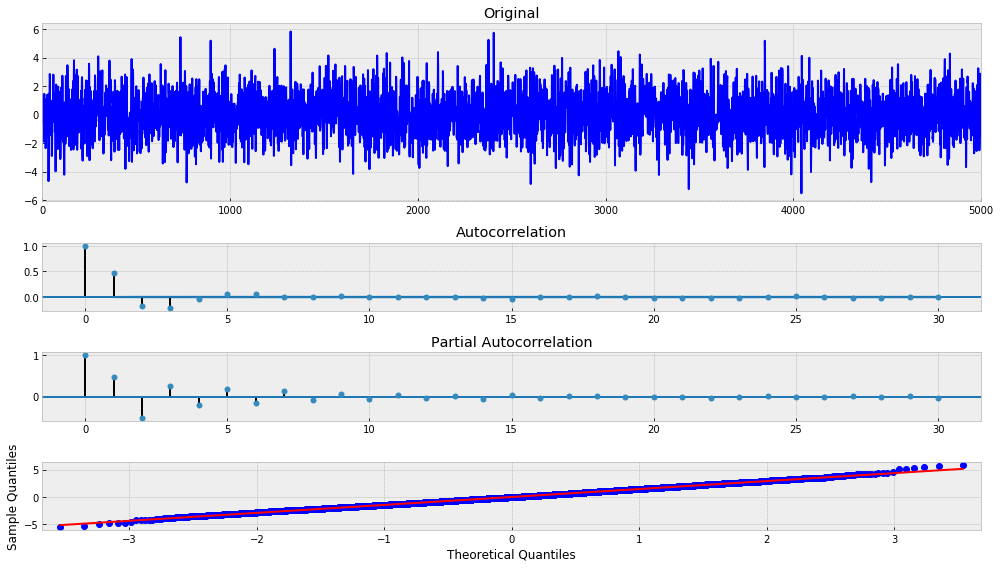

In [20]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

Применим модель ARMA к нашей TS

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1031: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


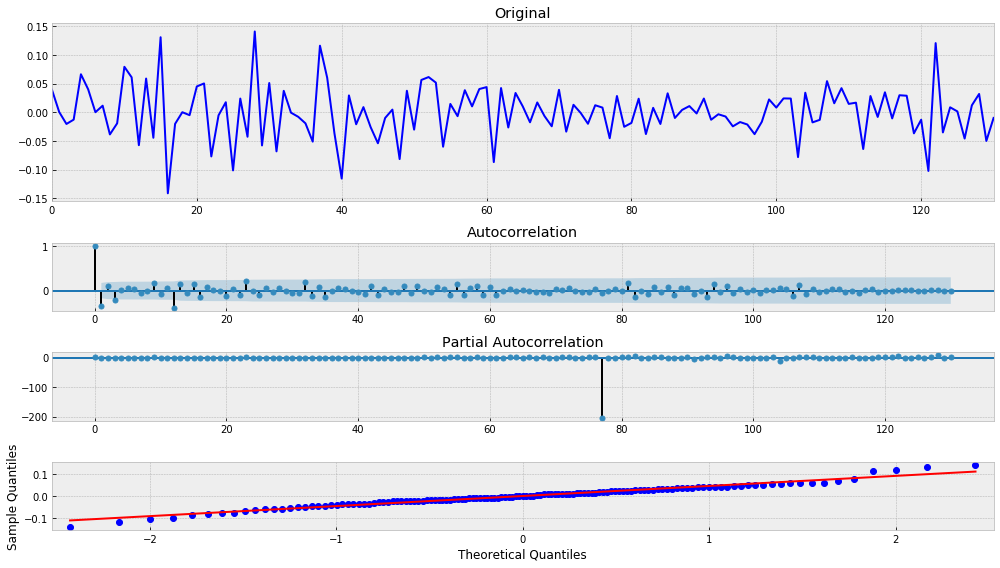

In [30]:
series = pd.read_csv("../data/international-airline-passengers.csv")
series.columns = ['Month', 'Count']
series = series['Count']

series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
series = series[:-1]
tsplot(series)

In [31]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -461.63881 | order: (4, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -4.343322
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


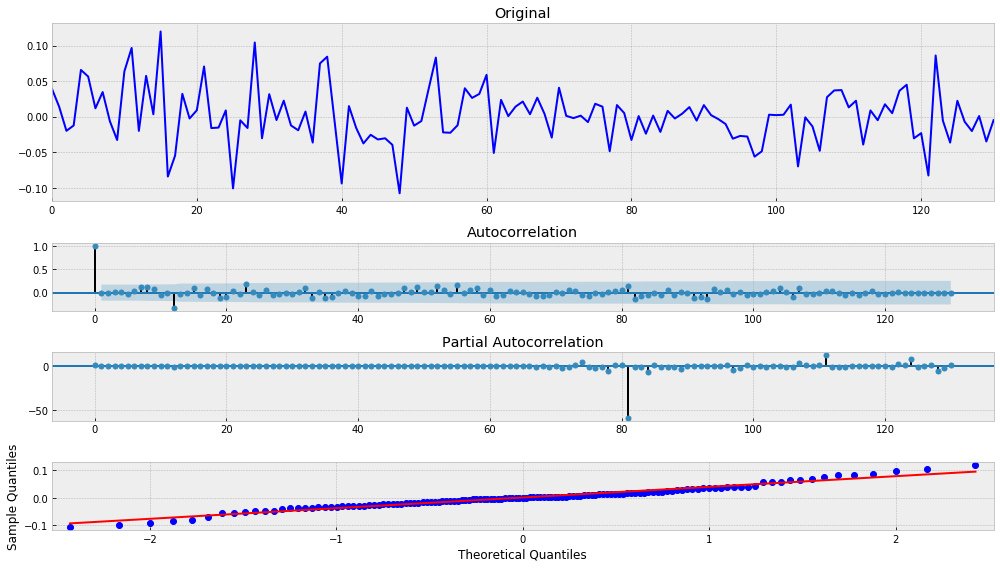

In [32]:
mdl = smt.ARMA(series, order=(4, 4)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

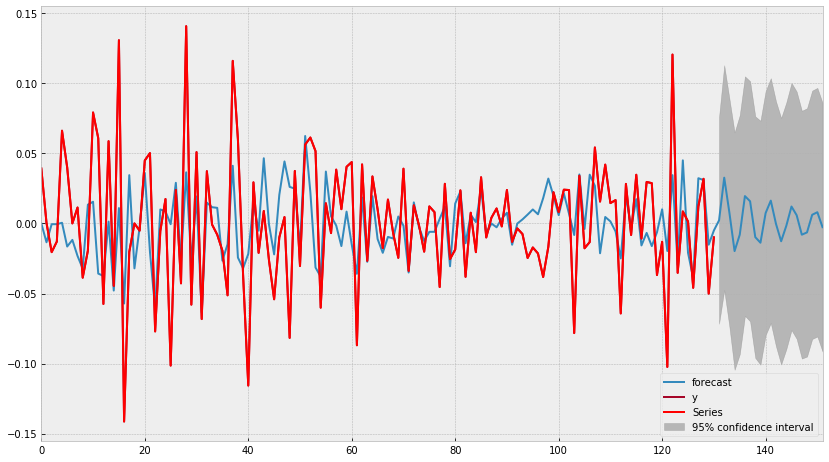

In [33]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -461.63881 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.343322
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


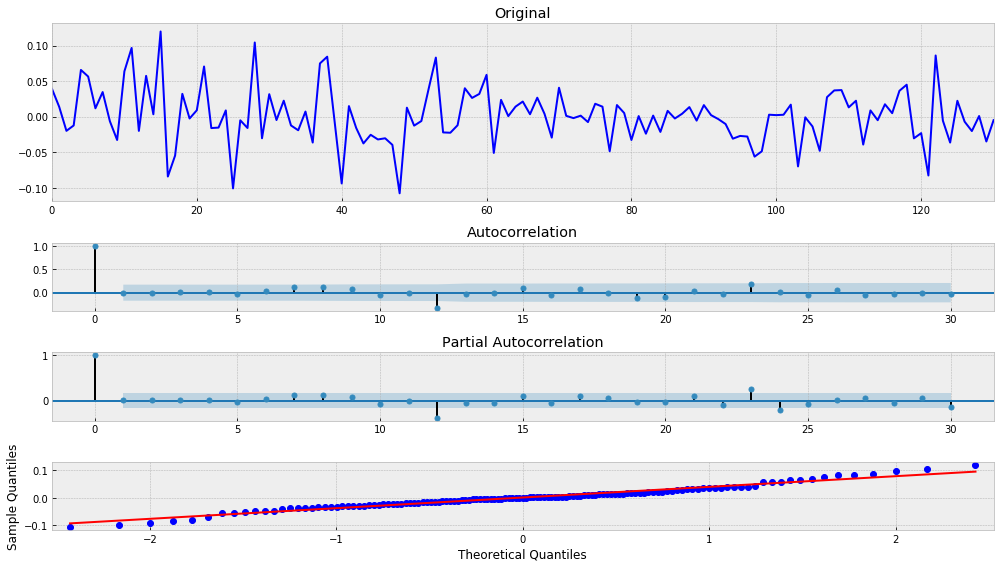

In [35]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

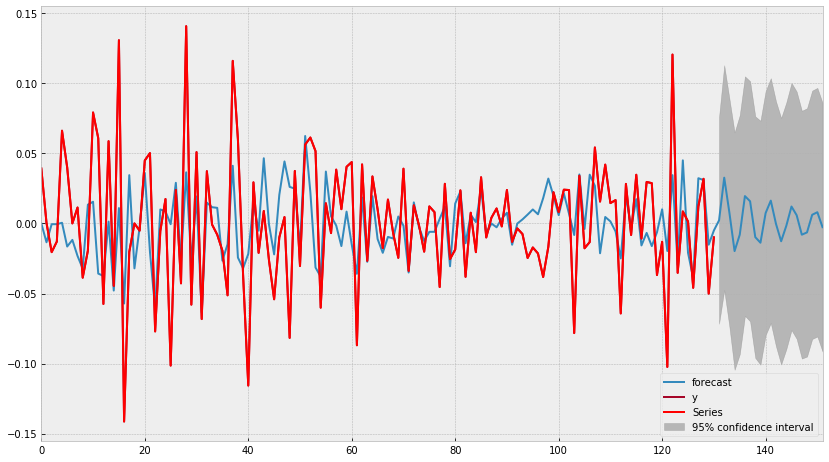

In [37]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.621932
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


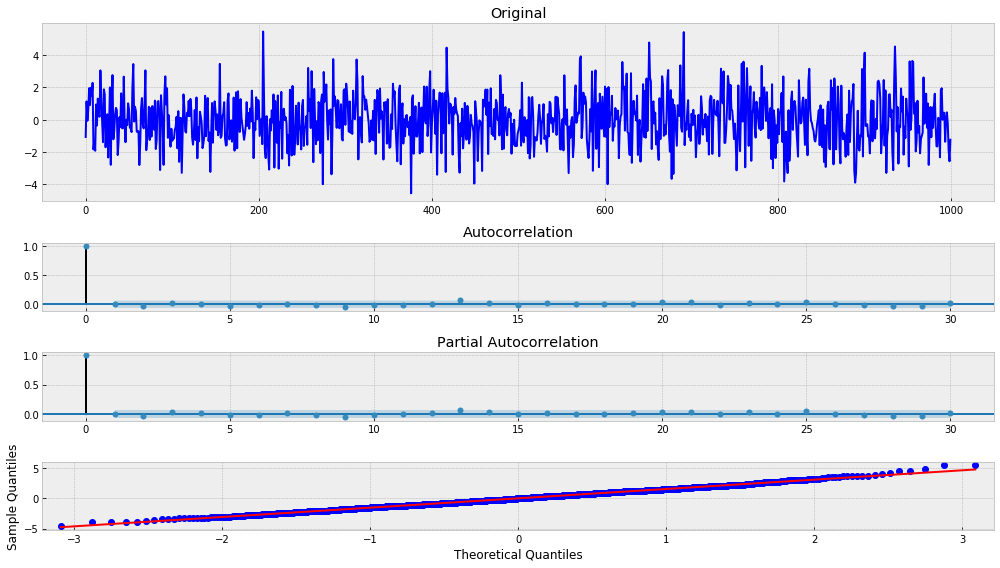

In [142]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [38]:
# !pip install arch
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [39]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -461.63881 | order: (4, 0, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -4.343322
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


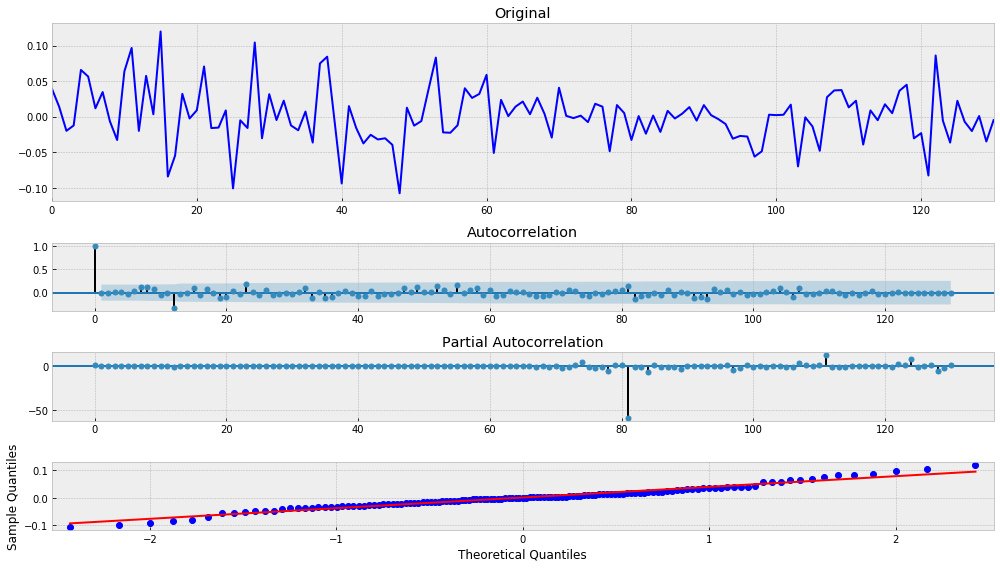

In [40]:
tsplot(mdl.resid)

Применим GARCH

In [41]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

C:\Users\mi\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                229.094
Distribution:      Standardized Student's t   AIC:                          -436.188
Method:                  Maximum Likelihood   BIC:                          -404.561
                                              No. Observations:                  131
Date:                      Tue, Mar 10 2020   Df Residuals:                      120
Time:                              23:02:04   Df Model:                           11
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


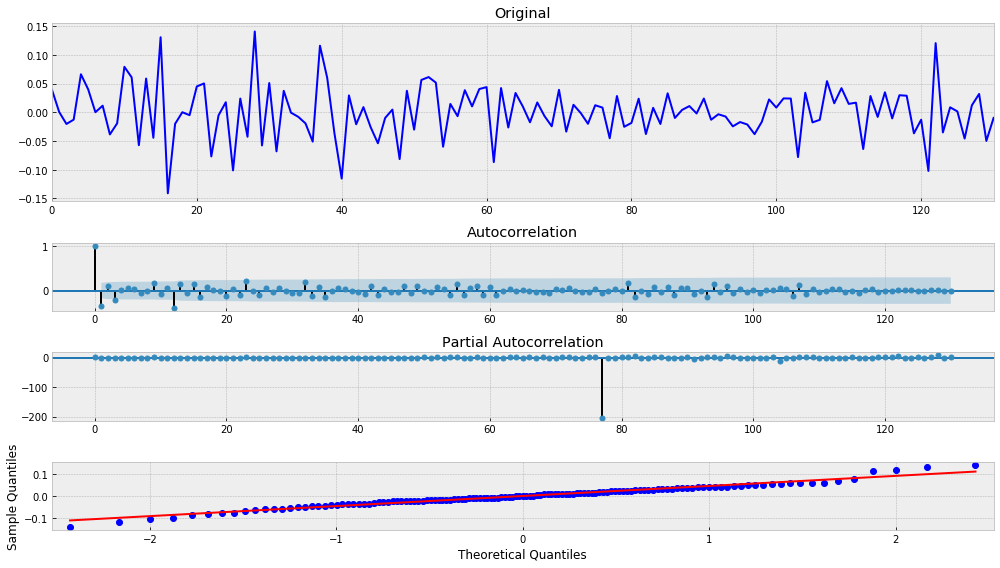

In [42]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


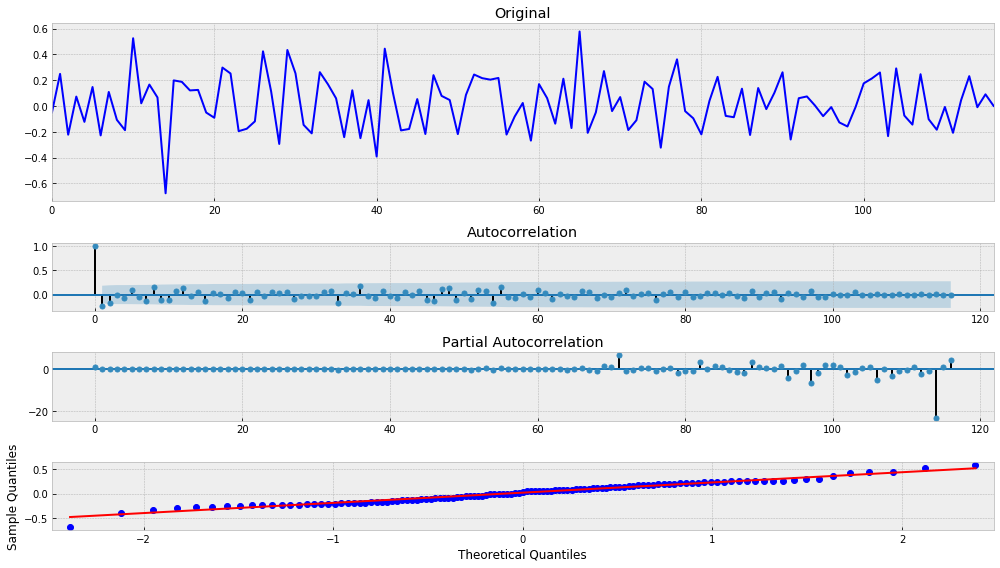

In [43]:
new_series = pd.read_csv("../data/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [44]:
aic, order, mdl = _get_best_model(new_series)


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -43.76716 | order: (4, 0, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.124484e+01
p-value                        1.770115e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


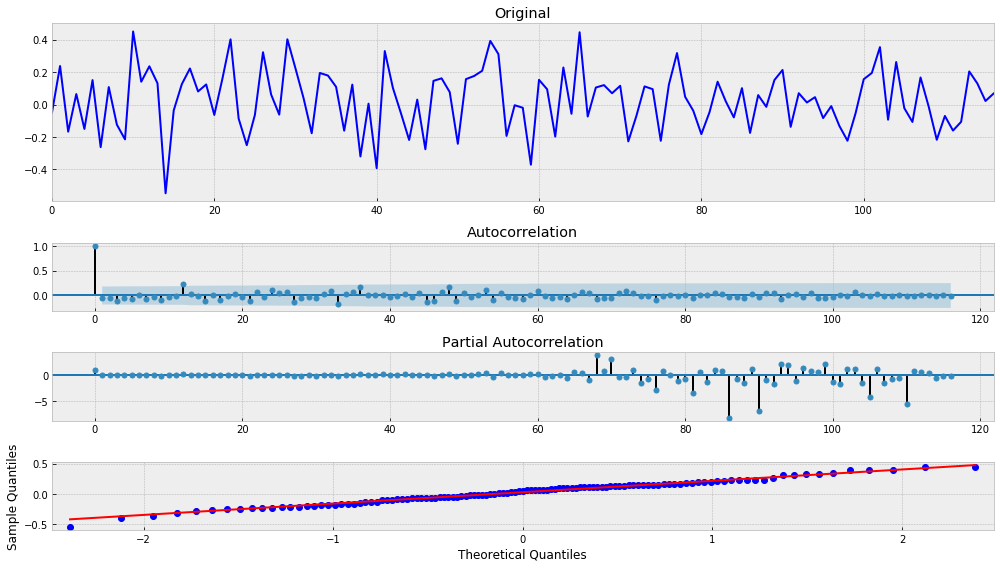

In [52]:
tsplot(mdl.resid)

In [53]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

C:\Users\mi\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      5,   Func. Count:     62,   Neg. LLF: -19.280779692584584
Iteration:     10,   Func. Count:    121,   Neg. LLF: -20.20239568165544
Iteration:     15,   Func. Count:    176,   Neg. LLF: -20.599678449506904
Iteration:     20,   Func. Count:    231,   Neg. LLF: -20.688491723739688
Iteration:     25,   Func. Count:    288,   Neg. LLF: -20.707366201226066
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.709932205924744
            Iterations: 28
            Function evaluations: 332
            Gradient evaluations: 28
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                20.7099
Distribution:      Standardized Student's t   AIC:                          -2

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


C:\Users\mi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


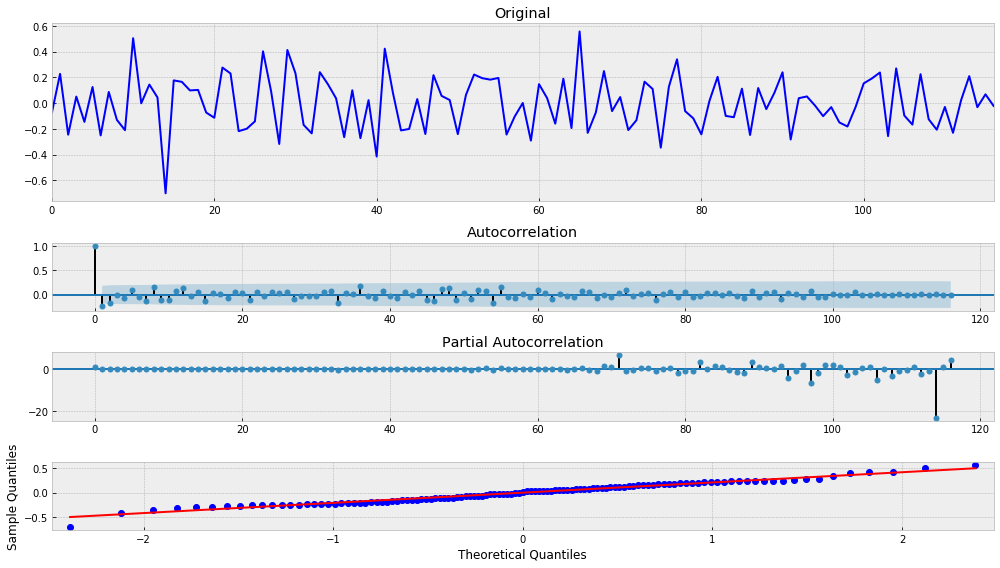

In [54]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [58]:
series = pd.read_csv("../data/international-airline-passengers.csv")
series.columns = ['Month', 'Count']

In [59]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [62]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

In [63]:
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
2,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
3,133.0,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
4,114.0,133.0,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


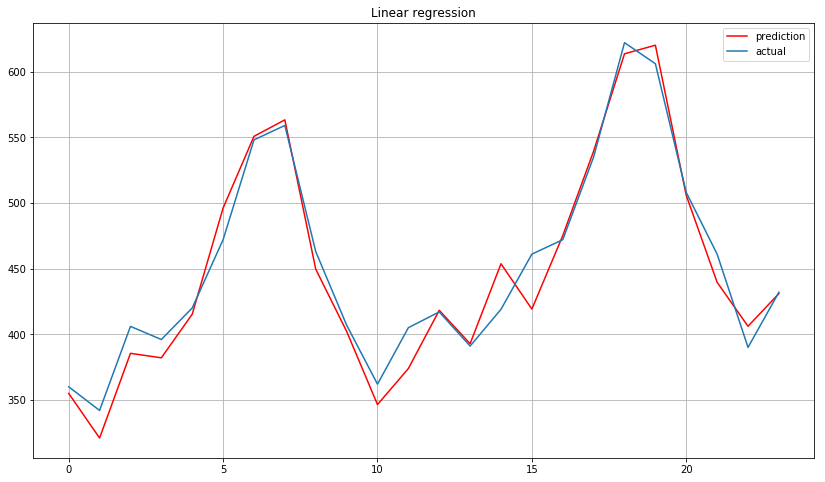

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016